In [24]:
import cv2
import argparse
import numpy as np
import os
import imutils
from keras.utils import to_categorical
from keras.models import load_model
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Function to load the images given the folder name
def load_folder(num_samples):
    imgs = []
    files = os.listdir('./MIO-TCD-Localization/train/')
    img_counter = 0
    for img in files:
        # Read the images in grayscale
        img = cv2.cvtColor(cv2.imread('./MIO-TCD-Localization/train/{img}'.format(img=img)), cv2.COLOR_BGR2GRAY)
        # Perform a box blur on the images
        kernel = np.array([[1/9,1/9,1/9], [1/9,1/9,1/9], [1/9,1/9,1/9]])
        img = cv2.filter2D(img, -1, kernel)
        # Resize to reduce computation time
        imgs.append(img)
        img_counter += 1
        if(img_counter==num_samples): break
    return imgs

images = load_folder(100)

In [14]:
model = load_model('my_model.h5')
enc = LabelEncoder()
classes = ['articulated_truck','background','bicycle','bus','car','motorcycle','non-motorized_vehicle','pedestrian','pickup_truck','single_unit_truck','work_van']
classes = enc.fit_transform(classes)
classes = to_categorical(classes)
for i in range(11):
    print('Encoding:',i, '- Label:', enc.inverse_transform(i))

Encoding: 0 - Label: articulated_truck
Encoding: 1 - Label: background
Encoding: 2 - Label: bicycle
Encoding: 3 - Label: bus
Encoding: 4 - Label: car
Encoding: 5 - Label: motorcycle
Encoding: 6 - Label: non-motorized_vehicle
Encoding: 7 - Label: pedestrian
Encoding: 8 - Label: pickup_truck
Encoding: 9 - Label: single_unit_truck
Encoding: 10 - Label: work_van


C:\Users\Antonios\Anaconda3\envs\my_root\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Antonios\Anaconda3\envs\my_root\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Antonios\Anaconda3\envs\my_root\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Antonios\Anaconda3\envs\my_root\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The tr

In [4]:
def pyramid(image, scale=1.5, minSize=(30, 30)):
	# yield the original image
	yield image
	# keep looping over the pyramid
	while True:
		# compute the new dimensions of the image and resize it
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
 
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image

In [65]:
def sliding_window(img, stride_x = 30, stride_y = 30, crop_size = 100):
    windows = []
    boxes = []
    for i in range(0, img.shape[0] - 10, stride_y):
        for j in range(0, img.shape[1] - 10, stride_x):
            windows.append(cv2.resize((img[i:i+crop_size, j:j+crop_size]), (32,32)))
            #windows.append(img[i:i+crop_size, j:j+crop_size])
            boxes.append((i, i+crop_size, j ,j+crop_size))
    return windows, boxes

def get_windows(img):
    windows = []
    coords = []
    big_windows, big_boxes = (sliding_window(img, stride_x = 250, stride_y = 250, crop_size = 250))
    mid_windows, mid_boxes = (sliding_window(img, stride_x = 100, stride_y = 100, crop_size = 100))
    small_windows, small_boxes = (sliding_window(img, stride_x = 30, stride_y = 30, crop_size = 30))
    windows.append(big_windows + mid_windows + small_windows)
    coords.append(big_boxes + mid_boxes + small_boxes)
    return windows, coords

def eval_window(window):
    window = cv2.resize(window, (32,32))
    window = np.array(window).reshape(-1,32,32,1)
    return enc.inverse_transform(np.argmax(model.predict(window)))

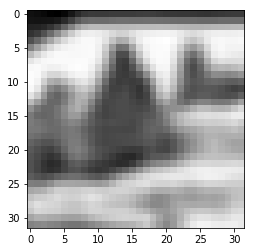

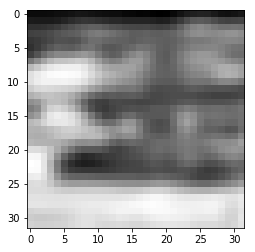

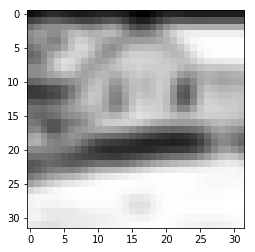

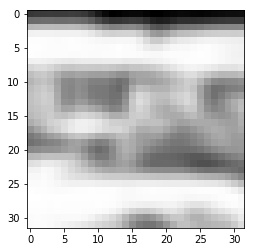

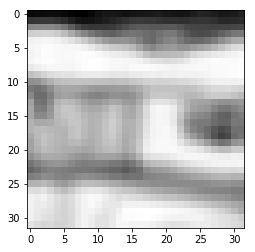

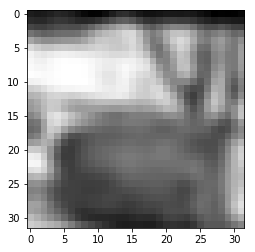

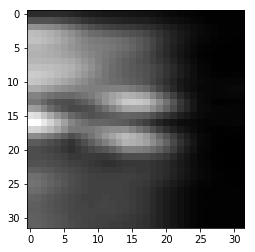

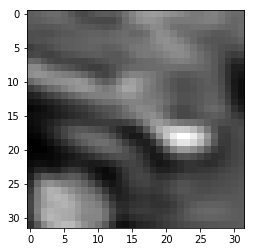

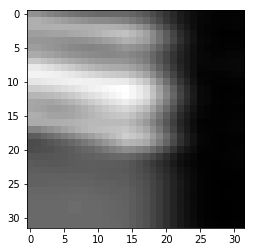

In [74]:
win, coo = get_windows(images[0])
win = np.array(win)
win = win.reshape(-1,32,32)
for window in win:
    clone = images[0].copy()
    if(eval_window(window))!='background':
        plt.figure()
        plt.imshow(window, cmap = 'gray')

210 240 60 90
(110, 32, 32)
(110, 4)


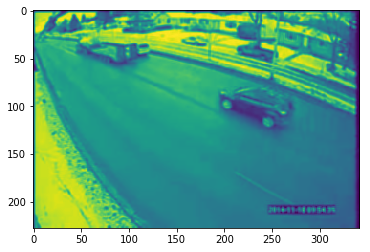

In [95]:
win, coo = get_windows(images[0])
win = np.array(win)
win = win.reshape(-1,32,32)
coo = np.array(coo)
coo = coo.reshape(win.shape[0],-1)
xi, xf, yi, yf = coo[100]
print(xi, xf, yi, yf)
print(win.shape)
print(coo.shape)
for i, window in enumerate (win):
    clone = images[0].copy()
    if(eval_window(window))!='background':
        xi, xf, yi, yf = coo[i]
        clone = cv2.rectangle(clone, (xi, yi), (xf, yf), (0, 0, 0), 25)
    plt.imshow(clone)